In [10]:
import os
import sys
from nltk.corpus import stopwords
import re
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [11]:
from pyspark.sql import SparkSession, SQLContext
import os
import pyspark.sql.functions as f
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()

In [12]:
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

In [13]:
classics = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/fanfics_raw.csv"))

In [14]:
classics.show()

+--------------------+--------------------+--------------------+
|                  id|                text|                type|
+--------------------+--------------------+--------------------+
|             1536152|           Chapter 1|                null|
|Going back was th...| after a case lik...| I’d be moved to ...|
|           Chapter 2|                null|                null|
|It was during my ...| Sophia was no lo...| especially since...|
|           Chapter 3|                null|                null|
|Following Sophia ...| I ducked in an e...| waiting under a ...|
|           Chapter 4|                null|                null|
|Aegis breaking in...| but when they ca...| barely managing ...|
|           Chapter 5|                null|                null|
|I hated coming to...|                sure| but everyone her...|
|           Chapter 6|                null|                null|
|             Somehow| this time was ev...| my instincts wer...|
|           Chapter 7|   

In [15]:
import string

In [16]:
classics_df = classics.withColumn('line', f.explode(f.split(f.col('text'), '\n')))
classics_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                  id|                text|                type|                line|
+--------------------+--------------------+--------------------+--------------------+
|             1536152|           Chapter 1|                null|           Chapter 1|
|Going back was th...| after a case lik...| I’d be moved to ...| after a case lik...|
|It was during my ...| Sophia was no lo...| especially since...| Sophia was no lo...|
|Following Sophia ...| I ducked in an e...| waiting under a ...| I ducked in an e...|
|Aegis breaking in...| but when they ca...| barely managing ...| but when they ca...|
|I hated coming to...|                sure| but everyone her...|                sure|
|             Somehow| this time was ev...| my instincts wer...| this time was ev...|
|The restaurant Li...| just off the Boa...| and without thos...| just off the Boa...|
|I managed to snea...| I tested for spe...| there were

In [17]:
classics = classics_df.rdd.map(lambda x : x['line']).filter(lambda x: x is not None)
StopWords = stopwords.words("english")
tokens = classics                                                  \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])    \
    .zipWithIndex()

In [18]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [19]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

In [20]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/12 19:11:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/04/12 19:11:55 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [21]:
classics_df.printSchema()
classics_df.show()

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- type: string (nullable = true)
 |-- line: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+
|                  id|                text|                type|                line|
+--------------------+--------------------+--------------------+--------------------+
|             1536152|           Chapter 1|                null|           Chapter 1|
|Going back was th...| after a case lik...| I’d be moved to ...| after a case lik...|
|It was during my ...| Sophia was no lo...| especially since...| Sophia was no lo...|
|Following Sophia ...| I ducked in an e...| waiting under a ...| I ducked in an e...|
|Aegis breaking in...| but when they ca...| barely managing ...| but when they ca...|
|I hated coming to...|                sure| but everyone her...|                sure|
|             Somehow| this time was ev...| my instincts wer...| this time was

In [22]:
lda_model.describeTopics().show()

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[104, 83, 108, 11...|[0.01290523094064...|
|    1|[11, 39, 73, 60, ...|[0.02849614855528...|
|    2|[3, 17, 16, 30, 1...|[0.04824472879398...|
|    3|[24, 37, 12, 95, ...|[0.02584484256496...|
|    4|[0, 5, 20, 38, 53...|[0.07270173050000...|
|    5|[22, 48, 76, 90, ...|[0.02315108776208...|
|    6|[56, 81, 123, 113...|[0.01756525255692...|
|    7|[13, 86, 59, 106,...|[0.01596439092064...|
|    8|[18, 32, 8, 1, 33...|[0.02034234025883...|
|    9|[27, 46, 47, 15, ...|[0.02385680720118...|
+-----+--------------------+--------------------+



/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [23]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

In [24]:
ldatopics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[104, 83, 108, 11...|[0.01290523094064...|[small, front, ta...|
|    1|[11, 39, 73, 60, ...|[0.02849614855528...|[think, well, mis...|
|    2|[3, 17, 16, 30, 1...|[0.04824472879398...|[says, rachel, be...|
|    3|[24, 37, 12, 95, ...|[0.02584484256496...|[susie, noelle, g...|
|    4|[0, 5, 20, 38, 53...|[0.07270173050000...|[said, know, eliz...|
|    5|[22, 48, 76, 90, ...|[0.02315108776208...|[darcy, need, sin...|
|    6|[56, 81, 123, 113...|[0.01756525255692...|[asked, almost, g...|
|    7|[13, 86, 59, 106,...|[0.01596439092064...|[much, least, han...|
|    8|[18, 32, 8, 1, 33...|[0.02034234025883...|[want, sure, time...|
|    9|[27, 46, 47, 15, ...|[0.02385680720118...|[good, might, alw...|
+-----+--------------------+--------------------+--------------------+



In [25]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))

lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[104, 83, 108, 11...|[0.01290523094064...|small front takin...|
|    1|[11, 39, 73, 60, ...|[0.02849614855528...|think well miss a...|
|    2|[3, 17, 16, 30, 1...|[0.04824472879398...|says rachel beca ...|
|    3|[24, 37, 12, 95, ...|[0.02584484256496...|susie noelle goin...|
|    4|[0, 5, 20, 38, 53...|[0.07270173050000...|said know elizabe...|
|    5|[22, 48, 76, 90, ...|[0.02315108776208...|darcy need since ...|
|    6|[56, 81, 123, 113...|[0.01756525255692...|asked almost gett...|
|    7|[13, 86, 59, 106,...|[0.01596439092064...|much least hands ...|
|    8|[18, 32, 8, 1, 33...|[0.02034234025883...|want sure time wo...|
|    9|[27, 46, 47, 15, ...|[0.02385680720118...|good might always...|
+-----+--------------------+--------------------+--------------------+



In [26]:
counts = lda_topics_mapped.withColumn('word', f.explode(f.split(f.col('topic_desc'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)

In [27]:
counts.show()

+---------+-----+
|     word|count|
+---------+-----+
|    quinn|    2|
|    still|    1|
|    leave|    1|
|   taking|    1|
|     sure|    1|
|     even|    1|
|   always|    1|
|elizabeth|    1|
|     hear|    1|
|     hand|    1|
|   rachel|    1|
|    chloe|    1|
|    along|    1|
|   rather|    1|
|   looked|    1|
|     love|    1|
|  friends|    1|
|     door|    1|
|     seat|    1|
|     tell|    1|
+---------+-----+
only showing top 20 rows



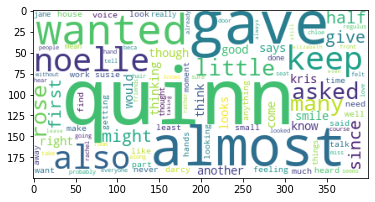

In [28]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*counts.select(F.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()
